## Global Imports

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.model_selection import KFold 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


## Functions used in Problem 2 - Questions 1i, 1ii

In [17]:
def implement_kNN(x, X_tr, Y_tr, k, dist_choice, cov_inv_matrices):
  """
    Implementation of the knn algorithm. Given a query point x, a training set (X_tr, Y_tr) and a distance metric, the algorithm finds the
    k-nearest neighbours of the query point in the train set. 
    Supports Euclidean, Manhattan and Mahalanobis metric. The last metric, as it is distribution dependent, requires the covariance matrices of
    all classes in training set.
  """
  distances = []

  if (dist_choice == "Euclidean"):
    distances = calculate_euclidean(x, X_tr)
  elif (dist_choice == "Mahalanobis"):
    distances = calculate_mahalanobis(x, X_tr, Y_tr, cov_inv_matrices)
  elif (dist_choice == "Manhattan"):
    distances = calculate_manhattan(x, X_tr)      
    
  # K-closest points to the query point.
  nn_ids = distances.argsort()[:k]
  # Classes of those points.
  nn_classes = Y_tr[nn_ids]
  b = nn_classes.flatten()
    
  # Return the class which has the majority.
  return np.bincount(b).argmax()

In [18]:
def produce_y_pred(X_tst, X_tr, Y_tr, k, dist_choice, cov_inv_matrices):
  """
    Makes predictions on a test set by using the knn algorithm.
  """  
  Y_pred = []

  for i in range(len(X_tst)):
    Y_pred.append(implement_kNN(X_tst[i], X_tr, Y_tr, k, dist_choice, cov_inv_matrices))

  return Y_pred

In [19]:
def cross_validation(k, m, dist_choice, cov_inv_matrices=[]):
  """
    Implements cross validation with k splits on a dataset, splitting it to a test dataset of size original_dataset/k and
    using the remaining dataset for training. This is repeated k times.
    The accuracies across all runs are averaged in order to give a more unbiased view of the accuracy in the whole dataset.
  """
  acc = []

  kf = KFold(n_splits=k, random_state=None)
  
  for i , j in kf.split(np_X):
    X_train , X_test = np_X[i,:], np_X[j,:]
    y_train , y_test = Y[i], Y[j]
     
    y_pred = produce_y_pred(X_test, X_train, y_train, m, dist_choice, cov_inv_matrices)
    
    a = accuracy_score(y_test, y_pred)
    acc.append(a)
     
  avg_acc = sum(acc)/k
  
  return avg_acc

## Distances 

In [20]:
def calculate_euclidean(x, X_tr):
  """
    Euclidean distance
  """
  x1 = np.array(X_tr - x, dtype=np.float64)
  return np.linalg.norm(x1, axis=1)

In [21]:
def calculate_mahalanobis(x, X_tr, Y_tr, cov_inv_matrices):
  """
    Mahalanobis distance, uses the inverse covariance matrices of all classes in the dataset.
  """
  distances = []

  for i, val in enumerate(X_tr):
    cov_inv = cov_inv_matrices[Y_tr[i][0]]
    
    dif = val - x
    left_factor = np.matmul(np.transpose(dif), cov_inv)
    distance = np.matmul(left_factor, dif)
    distances.append(distance)

  distances = np.array(distances, dtype=np.float64)
  return distances

In [22]:
def calculate_manhattan(x, X_tr):
  """
    Manhattan distance
  """
  return np.sum(np.abs(x-X_tr), axis=1)

## Problem 2 - Question 1i

We are going to implement a k nearest neighbours classifier (k-ΝΝ) in order to solve a classification problem using the IRIS PLANT DATABASE. There are three possible classes: "Iris Setosa", "Iris Versicolor" and "Iris Virginica" which we are going to map to values 0, 1 and 2 respectively.

## Dataset upload and preprocessing 

In [23]:
# Loads dataset and performs a random permutation of the rows.

df = pd.read_csv("./UCIdata-exercise1/iris.data", header= None)
np_A = df.values
np.take(np_A,np.random.permutation(np_A.shape[0]),axis=0,out=np_A)\

# Split to x and y vectors.
np_X = np_A[:, 0:4]
np_Y = np_A[:, [4]]

# Mapping of class string names to integers.
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

Y = np.zeros(np_Y.shape, dtype="int64")

for n, tup in mapping.items():
    Y[np_Y == n] = tup


# Creates covariance and inverse covariance matrices of the distribution of each class.
X_0 = []
X_1 = []
X_2 = []

for i, value in enumerate(np_X):
  if(Y[i] == 0):
    X_0.append(value)
  elif(Y[i] == 1):
    X_1.append(value)
  elif(Y[i] == 2):
    X_2.append(value)

X_0 = np.array(X_0, dtype=np.float64)
X_1 = np.array(X_1, dtype=np.float64)
X_2 = np.array(X_2, dtype=np.float64)


cov_0 = np.cov(X_0, rowvar=False)
cov_inv_0 = np.linalg.inv(cov_0)
cov_1 = np.cov(X_1, rowvar=False)
cov_inv_1 = np.linalg.inv(cov_1)
cov_2 = np.cov(X_2, rowvar=False)
cov_inv_2 = np.linalg.inv(cov_2)

cov_inv_matrices_1 = [cov_inv_0, cov_inv_1, cov_inv_2]


In order to classify an unlabeled vector x, what the kNN algorithm does is: it searches the whole training set in order to find the k nearest vectors to x, then it also finds the class with the most representatives among those k vectors, and assigns it to x.

We are going to implement the kNN algorithm for various values of k. 

Also, for each k, we are implementing K-fold cross validation in order to assess the performane of our algorithm.

According to this method, we split our dataset into K roughly equal sized parts. We implement training K times, and each time we select one different part of the data for testing, and leave the remaining K-1 parts for training.
This gives us the advantage of performing testing on a part of the dataset that has not been used in the training process, and at the same time using all of our data both for training and for testing. This generally produces less biased models.

We are going to implement it for K = 10 (which is a very common choice for K).
Each of those 10 times we calculate the accuracy of our y_pred, and once we ve finished with the whole process, we combine our results by averaging them.


We will use three different metrics/distances for finding the nearest neighbours, which are the folowing. The notation $d(x,y)$ indicates the distance of $x$ from $y$.
* Euclidean distance : $d(x,y)=\sqrt{\sum_{i=0}^{n-1}(x_i-y_i)^2}$
* Manhattan distance : $d(x,y)=\sum_{i=0}^{n-1}|x_i-y_i|$
* Mahalanobis distance : $d(x,y)=(x-y)^T\Sigma^{-1}(x-y)$, where $\Sigma$ is the covariance matrix of the distribution followed by $y$.


In [24]:
# Number of nearest neighboors we are going to use
# 1-19 with step = 1
# 20-48 with step = 2
# 50-100 with step = 5
# Since the classes are not binary, we are not restricted to only odd values of k.

num_of_nn_1 = [i for i in range(1, 20)]
num_of_nn1_1 = [i for i in range(20, 50, 2)]
num_of_nn2_1 = [i for i in range(50, 105, 5)]
num_of_nn1_1.extend(num_of_nn2_1)
num_of_nn_1.extend(num_of_nn1_1)
print(num_of_nn_1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [25]:
# We will create vectors contain the average accuracy we get from K-fold cross validation for each k and for each distance.

# Euclidean distance
avg_acc_collection_Euc_1 = []

for i in num_of_nn_1:  
    avg_acc = cross_validation(10, i, "Euclidean")
    avg_acc_collection_Euc_1.append(avg_acc)

print(f"Average accuracies from knn using Euclidean distance: {avg_acc_collection_Euc_1}")

# Manhattan distance
avg_acc_collection_Man_1 = []

for i in num_of_nn_1:  
    avg_acc = cross_validation(10, i, "Manhattan")
    avg_acc_collection_Man_1.append(avg_acc)

print(f"Average accuracies from knn using Manhattan distance: {avg_acc_collection_Man_1}")

# Mahalanobis distance - the only distance which uses the covariance matrices calculated previously.
avg_acc_collection_Mah_1 = []

for i in num_of_nn_1:  
    avg_acc = cross_validation(10, i, "Mahalanobis", cov_inv_matrices_1)
    avg_acc_collection_Mah_1.append(avg_acc)

print(f"Average accuracies from knn using Mahalanobis distance: {avg_acc_collection_Mah_1}")

Average accuracies from knn using Euclidean distance: [0.9600000000000002, 0.9466666666666667, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9600000000000002, 0.96, 0.9733333333333334, 0.9733333333333334, 0.9666666666666668, 0.9800000000000001, 0.9733333333333334, 0.9666666666666666, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9800000000000001, 0.9666666666666668, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334, 0.9400000000000001, 0.9466666666666667, 0.9533333333333334, 0.9466666666666667, 0.96, 0.9466666666666667, 0.9466666666666667, 0.9466666666666667, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9133333333333334, 0.9066666666666668, 0.9000000000000001, 0.9000000000000001, 0.8866666666666667, 0.8866666666666667, 0.8800000000000001, 0.8266666666666668, 0.6533333333333333, 0.6, 0.5599999999999999]
Average accuracies from knn using Manhattan distance: [0.9533333333333334, 0.93333333333

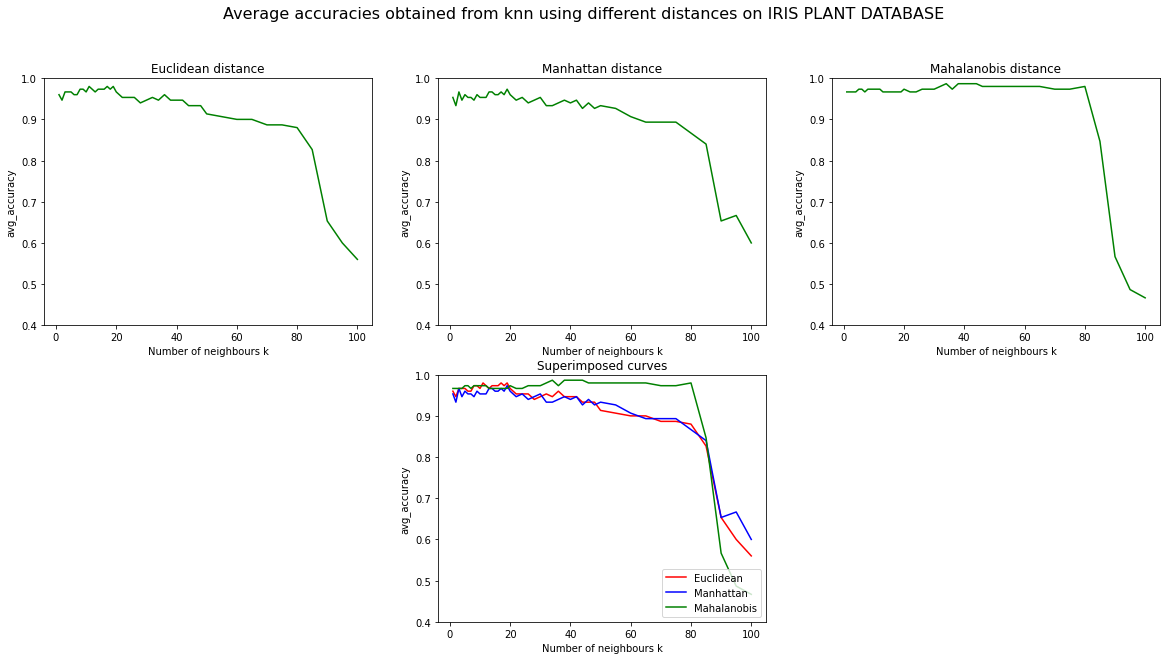

In [26]:
# Plot of average accuracies
fig, axs = plt.subplots(2,3, figsize=(20,10))

custom_ylim = (0.4, 1.0)
plt.setp(axs, ylim=custom_ylim)

axs[0,0].plot(num_of_nn_1, avg_acc_collection_Euc_1, c = "green")
axs[0,1].plot(num_of_nn_1, avg_acc_collection_Man_1, c = "green")
axs[0,2].plot(num_of_nn_1, avg_acc_collection_Mah_1, c = "green")
axs[1,0].set_visible(False)
axs[1,1].plot(num_of_nn_1, avg_acc_collection_Euc_1, c = "red", label="Euclidean")
axs[1,1].plot(num_of_nn_1, avg_acc_collection_Man_1, c = "blue", label="Manhattan")
axs[1,1].plot(num_of_nn_1, avg_acc_collection_Mah_1, c = "green", label="Mahalanobis")
axs[1,2].set_visible(False)

fig.suptitle("Average accuracies obtained from knn using different distances on IRIS PLANT DATABASE", fontsize=16)
axs[0,0].title.set_text('Euclidean distance')
axs[0,1].title.set_text('Manhattan distance')
axs[0,2].title.set_text('Mahalanobis distance')
axs[1,1].title.set_text('Superimposed curves')

axs[0,0].set_xlabel('Number of neighbours k')
axs[0,0].set_ylabel('avg_accuracy')
axs[0,1].set_xlabel('Number of neighbours k')
axs[0,1].set_ylabel('avg_accuracy')
axs[0,2].set_xlabel('Number of neighbours k')
axs[0,2].set_ylabel('avg_accuracy')
axs[1,1].set_xlabel('Number of neighbours k')
axs[1,1].set_ylabel('avg_accuracy')

axs[1,1].legend(loc="lower right")


## Comments

For the Euclidean and Manhattan distances, we can easily observe from the graph above that we've managed to score a good acuracy in our predictions, which however decreases as the number of k goes up. The differences in the average accuracies between these two metrics are not very large but for k in the range of 10-20, Euclidean distance is the winner.


Mahalanobis distance is scale-invariant, unitless and takes into consideration the correlation between variables. In this case we observe, that overally the Mahalanobis distance scores better accuracy and manages to maintain it for very large values of k as well, for which the accuracy scored with the other two distances drops.

## Problem 2 - Question 1ii

We are going to implement a k nearest neighbours classifier (k-ΝΝ) in order to solve a classification problem using the PIMA INDIANS DIABETES DATABASE. There are two possible classes: "tested positive for diabetes", "tested not positive for diabetes" which we are going to map to values 1 and 0 respectively.

## Dataset upload and preprocessing 

In [27]:
#Preprocessing as before.

df = pd.read_csv("./UCIdata-exercise1/pima-indians-diabetes.data", header= None)

np_A = df.values
np.take(np_A,np.random.permutation(np_A.shape[0]),axis=0,out=np_A)

np_X = np_A[:, 0:8]  
Y = np_A[:, [8]]
Y = np.array(Y, dtype=np.int64)

X_0 = []
X_1 = []


for i, value in enumerate(np_X):
  if(Y[i] == 0):
    X_0.append(value)
  elif(Y[i] == 1):
    X_1.append(value)

X_0 = np.array(X_0, dtype=np.float64)
X_1 = np.array(X_1, dtype=np.float64)

cov_0 = np.cov(X_0, rowvar=False)
cov_inv_0 = np.linalg.inv(cov_0)
cov_1 = np.cov(X_1, rowvar=False)
cov_inv_1 = np.linalg.inv(cov_1)

cov_inv_matrices_2 = [cov_inv_0, cov_inv_1]

As before we are implementing the kNN algorithm for the same numbers of k, and we are going to assess the performance of our algorithm using K-fold cross validation for K=10. We are going to use the distances we used before. 

Here, the problem is binary classification (2 classes) and we have to use odd values for k in order to get the majority of votes for which class to classify a query point.

In [28]:
# Number of nearest neighboors we are going to use. The task is binary classification so only odd values are chosen.
# 1-19 with step = 2
# 21-49 with step = 4
# 51-99 with step = 6

num_of_nn_2 = [i for i in range(1, 20, 2)]
num_of_nn1_2 = [i for i in range(21, 50, 4)]
num_of_nn2_2 = [i for i in range(51, 100, 6)]
num_of_nn1_2.extend(num_of_nn2_2)
num_of_nn_2.extend(num_of_nn1_2)
print(num_of_nn_2)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 25, 29, 33, 37, 41, 45, 49, 51, 57, 63, 69, 75, 81, 87, 93, 99]


In [29]:
# We will create vectors contain the average accuracy we get from K-fold cross validation for each k and for each distance.

# Euclidean distance
avg_acc_collection_Euc_2 = []

for i in num_of_nn_2:  
    avg_acc = cross_validation(10, i, "Euclidean")
    avg_acc_collection_Euc_2.append(avg_acc)

print(f"Average accuracies from k-nn using Euclidean distance: {avg_acc_collection_Euc_2}")

# Manhattan distance
avg_acc_collection_Man_2 = []

for i in num_of_nn_2:  
    avg_acc = cross_validation(10, i, "Manhattan")
    avg_acc_collection_Man_2.append(avg_acc)

print(f"Average accuracies from knn using Manhattan distance: {avg_acc_collection_Man_2}")

# Mahalanobis distance - the only distance which uses the covariance matrices calculated previously.
avg_acc_collection_Mah_2 = []

for i in num_of_nn_2:  
    avg_acc = cross_validation(10, i, "Mahalanobis", cov_inv_matrices_2)
    avg_acc_collection_Mah_2.append(avg_acc)

print(f"Average accuracies from knn using Mahalanobis distance: {avg_acc_collection_Mah_2}")

Average accuracies from k-nn using Euclidean distance: [0.6705058099794942, 0.691473000683527, 0.7148838004101161, 0.7293062200956937, 0.7253759398496241, 0.7370984278879016, 0.7435748462064252, 0.743609022556391, 0.7448735475051265, 0.738414217361586, 0.7410287081339713, 0.7383971291866029, 0.7319036226930964, 0.727904989747095, 0.7370984278879016, 0.7304853041695147, 0.7214114832535887, 0.7253417634996582, 0.7279733424470266, 0.7305878332194122, 0.7305707450444293, 0.7266575529733427, 0.7344326725905674, 0.7318352699931647, 0.7397129186602871, 0.7227443609022557, 0.7213773069036227]
Average accuracies from knn using Manhattan distance: [0.6862098427887902, 0.6861756664388243, 0.7279049897470949, 0.7175324675324675, 0.7188311688311689, 0.7409603554340396, 0.7448735475051265, 0.7540157211209844, 0.7514354066985646, 0.7514524948735476, 0.7501196172248804, 0.7501537935748461, 0.739712918660287, 0.740909090909091, 0.7409603554340396, 0.7409945317840054, 0.7436090225563909, 0.7514183185235

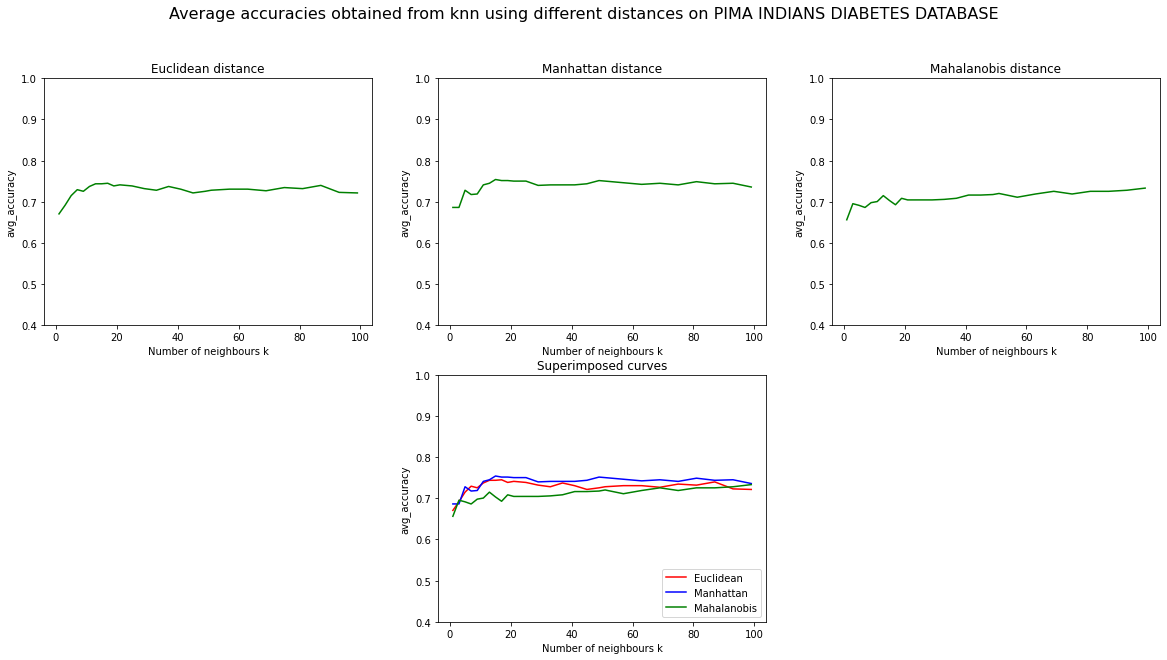

In [30]:
# Plot of average accuracies
fig, axs = plt.subplots(2,3, figsize=(20,10))

custom_ylim = (0.4, 1.0)
plt.setp(axs, ylim=custom_ylim)

axs[0,0].plot(num_of_nn_2, avg_acc_collection_Euc_2, c = "green")
axs[0,1].plot(num_of_nn_2, avg_acc_collection_Man_2, c = "green")
axs[0,2].plot(num_of_nn_2, avg_acc_collection_Mah_2, c = "green")
axs[1,0].set_visible(False)
axs[1,1].plot(num_of_nn_2, avg_acc_collection_Euc_2, c = "red", label="Euclidean")
axs[1,1].plot(num_of_nn_2, avg_acc_collection_Man_2, c = "blue", label="Manhattan")
axs[1,1].plot(num_of_nn_2, avg_acc_collection_Mah_2, c = "green", label="Mahalanobis")
axs[1,2].set_visible(False)

fig.suptitle("Average accuracies obtained from knn using different distances on PIMA INDIANS DIABETES DATABASE", fontsize=16)
axs[0,0].title.set_text('Euclidean distance')
axs[0,1].title.set_text('Manhattan distance')
axs[0,2].title.set_text('Mahalanobis distance')
axs[1,1].title.set_text('Superimposed curves')

axs[0,0].set_xlabel('Number of neighbours k')
axs[0,0].set_ylabel('avg_accuracy')
axs[0,1].set_xlabel('Number of neighbours k')
axs[0,1].set_ylabel('avg_accuracy')
axs[0,2].set_xlabel('Number of neighbours k')
axs[0,2].set_ylabel('avg_accuracy')
axs[1,1].set_xlabel('Number of neighbours k')
axs[1,1].set_ylabel('avg_accuracy')

axs[1,1].legend(loc="lower right")

## Comments
In this case, we observe that the accuracy we score is in generally lower than before for all distance metrics.

Also here, small k's give us the worst accuracies. As the values of k increase, so does the accuracy. For very large k's we observe that our accuracy plateaus first and then decreases again but not as fast as it did in the previous dataset. Those observations hold for all distances.

Again, we observe that the Mahalanobis distance manages to maintain high accuracies for large values of k but doesn't outperform the other two. However in this dataset, the largest accuracy overall, is scored using the Manhattan distance for k=21.